# dask (分布式计算框架)
![dask](dask.png)



## 简要介绍
**Dask是一款用于分析计算的灵活并行计算库，它有两部分组成：**
+ 针对计算优化的动态任务调度。这与Airflow，Luigi，Celery或Make类似，但针对交互式计算工作负载进行了优化。
+ 大数据”集合像并行数组，数据框和列表，它们将常见接口（如NumPy，Pandas或Python迭代器）扩展到大于内存或分布式环境。这些并行集合运行在动态任务调度器之上。
***

**Dask vs Spark**
+ 语言
    * Spark是用Scala编写的，支持Python和R. 作为一个python开发者会觉得特别不友好， 开发过程遇到问题会弹出一大串java代码，调试艰难.
    * Dask是用Python编写的，只支持python。 但是Python是门胶水语言，可以跟c/c++完美交互。
+ 生态系统
    * Spark的生态系统是个一体化项目，并且与其他Apache项目有很好的集成
    * Dask是强大的Python生态系统的组件。它与NumPy，Pandas和Scikit-Learn等其他第三方库结合并加强其功能。
+ 可信度
    * Spark（自2010年起），在大数据中占统治地位。
    * Dask年轻（从2014年开始），是深受信赖的NumPy / Pandas / Scikit-learn / Jupyter系列的延伸。
+ 关注范围
    * Spark专注于传统的商业智能操作，如SQL和轻量级机器学习。
    * Dask更广泛地应用于商业智能应用程序
+ 内部设计
    * Spark的内部模型是更高层次的，对统一应用的计算提供了很好的高级优化，但对于更复杂的算法或特定系统缺乏灵活性。它基本上是Map-Shuffle-Reduce范式的扩展。
    * Dask的内部模型较低，因此缺少高级优化，但能够实现更复杂的算法并构建更复杂的定制系统。它基本上基于通用任务调度
+ 规模
    * Spark从单个节点扩展到千个节点的集群
    * Dask从单个节点扩展到千个节点的集群
+ 流式计算
    * Spark对数据流的支持是一流的，并且可以很好地集成到其他API中。它遵循小批量方法。这为大型统一流式传输操作提供了良好的性能
    * Dask提供实时的'futrues'接口，低于spark的streaming。这可以实现更多创造性和复杂的用例，但需要比SparkA做更多的工作。
***
**选择Dask的理由**
1. "Pythonic"。 如果你更喜欢python代码的话
2. "轻量"。从本地计算到集群计算实现轻量级转换
3. "插件"。如果你不介意安装多个第三方库
*** 

### 快速上手

In [1]:
%%time 

from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def double(x):
    sleep(2)
    return x * 2

def add(a, b):
    return a + b
add(inc(1), double(2))

CPU times: user 1.01 ms, sys: 2.06 ms, total: 3.07 ms
Wall time: 3 s


**Dask的delayed函数装饰你的函数为一个任务。而不是立即执行你的函数，它会推迟执行，把函数和它的参数放到任务图中.**

In [2]:
%%time
from dask.delayed import delayed
from time import sleep

@delayed
def inc(x):
    sleep(1)
    return x + 1

@delayed
def double(x):
    sleep(2)
    return x * 2

@delayed
def add(a, b):
    return a + b

a = inc(1)
b = double(2)
c = add(a, b)
c.compute()


CPU times: user 226 ms, sys: 202 ms, total: 428 ms
Wall time: 2.53 s


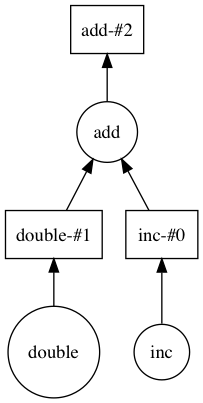

In [3]:
c.visualize()

In [4]:
%%time
import pandas as pd

files = ['data1/1.csv',
         'data1/2.csv',
         'data1/3.csv',
         'data1/4.csv']

result = []
for file in files:
    df = pd.read_csv(file)

    # Count value > 980
    count = df[df['Value'] > 980].count()

    result.append(count)

print(sum(result) / len(result))



Key      6452051.0
Value    6452051.0
dtype: float64
CPU times: user 12.7 s, sys: 2.71 s, total: 15.4 s
Wall time: 17.7 s


In [5]:
%%time 
from dask.delayed import delayed

result = []
for file in files:
    df = delayed(pd.read_csv)(file)
    
    # Count value > 980
    count = df[df['Value'] > 980].count()

    result.append(count)

avg = delayed(lambda a: sum(a) / len(a))(result)
avg.compute()

CPU times: user 17.8 s, sys: 4.92 s, total: 22.8 s
Wall time: 9.8 s


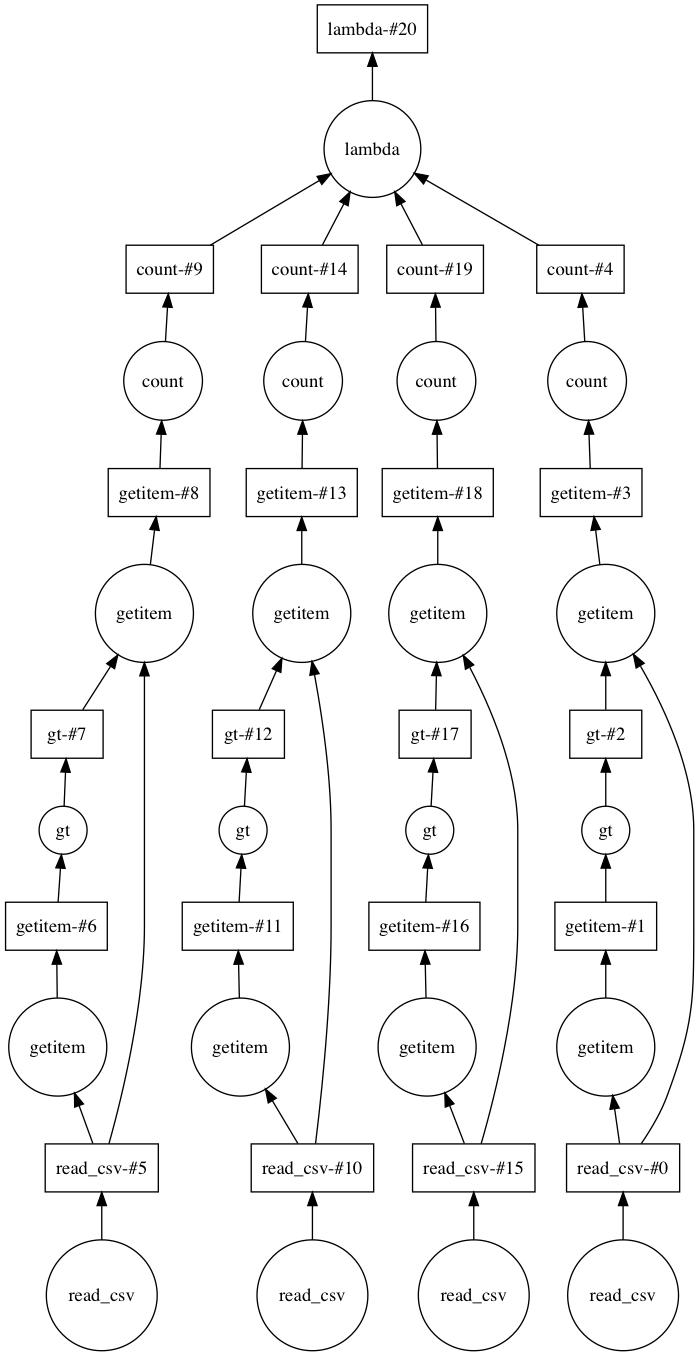

In [6]:
avg.visualize()

### 编程进阶
    
    Dask主要有3种对象进行并行运算，分别是:
* Dask Dataframe  
* Dask Array      
* Dask Bag  
***
    
#### Dask DataFrame
Dask DataFrame是一个大型并行数据框，由许多较小的Pandas数据框组成，沿着索引分割。这些Pandas数据框可以存放在磁盘上，以便在单台机器上或集群中的许多不同机器上进行大于内存的计算。一个Dask数据帧操作会触发构成Pandas数据框的许多操作。    

In [1]:
%%html
<img src="dask-dataframe.png" width="30%">

**Dask DataFrame的api复制了pandas的api**

In [8]:
import pandas as pd
import dask.dataframe as dd

df = pd.read_csv('data1/1.csv')
df1 = dd.read_csv('data1/1.csv')
df['Key'].count()
df1['Key'].count()

dd.Scalar<series-..., dtype=int64>

** 转换pandas的DataFrame为dask的DaskFrame **

In [9]:
ddf = dd.from_pandas(df, npartitions=3)
ddf

,Key,Value
npartitions=3,,
0,int64,int64
3333334,...,...
6666668,...,...
9999999,...,...
